These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q$.

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def step(system, dt, p, q, s, t):
    # dummy here
    t += dt

    # dt/2 C
    q += s*dt/2.
    p /= 1. + p*dt/2.

    # dt/2 B
    p -= system.Vq(q)*dt/2
    s -= system.V(q)*dt/2

    # dt A
    if np.abs(system.f(q)) < np.finfo(float).eps:
        p -= system.fq(q)*s*dt
    else:
        p = (p + system.fq(q)*s/system.f(q))*np.exp(-dt*system.f(q))

    s *= np.exp(-dt*system.f(q))

    # dt/2 B
    p -= system.Vq(q)*dt/2
    s -= system.V(q)*dt/2

    # dt/2 C
    q += s*dt/2.
    p /= 1. + p*dt/2.

    return (p, q, s, t)

def step6(system, dt, p, q, s, t):
    return ic.step6(system, dt, p, q, s, t, stepper=step)

In [4]:
class Lienard:
    def __init__(self, f, fq, F, Fq):
        self.f = f
        self.fq = fq
        self.F = F
        self.Fq = Fq
    
    def f(self, q):
        return self.f(q)
    
    def fq(self, q):
        return self.fq(q)
    
    def V(self, q):
        return self.F(q)
    
    def Vq(self, q):
        return self.Fq(q)

In [5]:
def vanDerPol(epsilon):
    
    def f(q):
        return -epsilon*(1 - q**2)
    def fq(q):
        return 2*epsilon*q
    def F(q):
        return q
    def Fq(q):
        return 1
    
    return Lienard(f, fq, F, Fq)

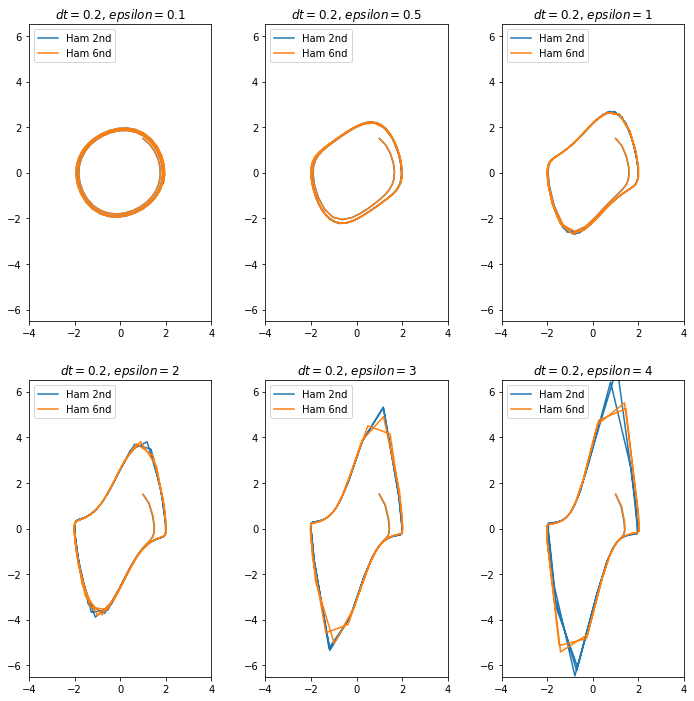

In [6]:
dt = 0.2
tf = 20
p0, q0, s0 = 0.0, 1.0, 1.5

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    vdp = vanDerPol(epsilon)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step, vdp, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
    #solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)

    plt.plot(sol[:,1], sols,
             label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             label="Ham 6nd")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-4,4))
    plt.ylim((-6.5,6.5))

    plt.legend(loc='upper left')

plt.show()

In [10]:
from scipy import integrate as si

Number of function evaluations: 494033, number of Jacobian evaluations: 11491


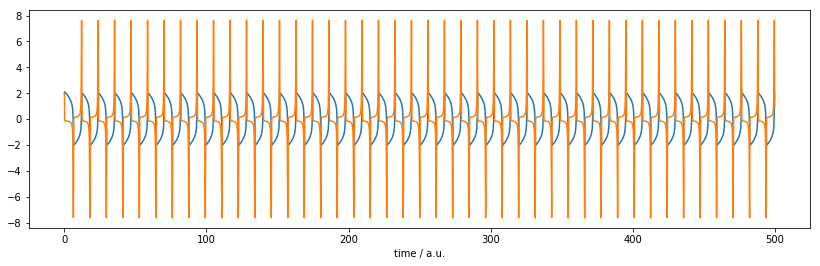

In [61]:
def ivp_vdp(y, t, mu):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0]
    ]

def my_plot(tout, yout, params, xlbl='time / a.u.', ylabel=None, analytic=None):
    fig, axes = plt.subplots(1, 2 if analytic else 1, figsize=(14, 4))
    axes = np.atleast_1d(axes)
    for i in range(yout.shape[1]):
        axes[0].plot(tout, yout[:, i], label='y%d' % i)
    if ylabel:
        axes[0].set_ylabel(ylabel)
    for ax in axes:
        ax.set_xlabel(xlbl)
    if analytic:
        axes[0].plot(tout, analytic(tout, yout, params), '--')
        axes[1].plot(tout, yout[:, 0] - yout[0]*np.exp(-params[0]*(tout-tout[0])))
        if ylabel:
            axes[1].set_ylabel('Error in ' + ylabel)

tout = np.linspace(0, 500, 25000)

y_init, params = [2, 2], (5,)

y_odeint, info = si.odeint(ivp_vdp, y_init, tout, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))
my_plot(tout, y_odeint, params)

In [83]:
vdp = vanDerPol(5)
jump = 3
tout2 = np.linspace(0, 500, 25000*jump)


q0, s0 = 2, 2

sol, sols, _ = ic.integrate(step, vdp, tout2, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, vdp, tout2, p0, q0, s0)

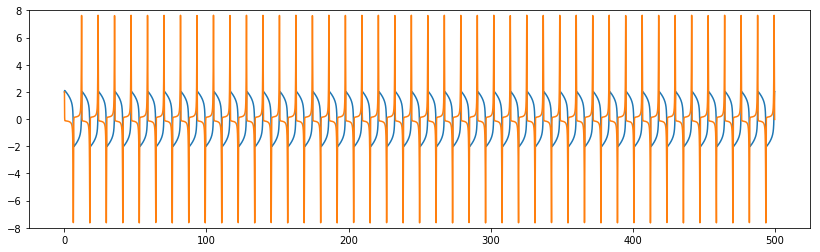

In [84]:
plt.figure(figsize=(14,4))

plt.plot(tout,
         sol[:,1][::jump])
plt.plot(tout,
         sols[::jump])
plt.ylim((-8,8))
plt.show()

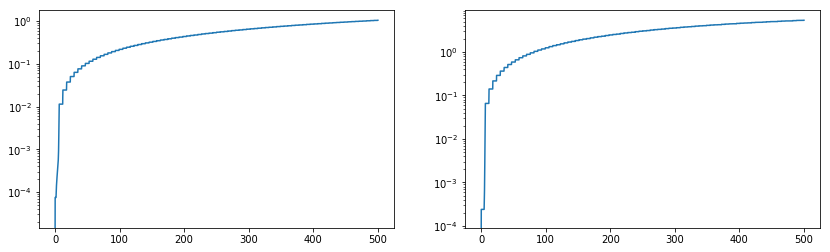

In [85]:
plt.figure(figsize=(14,4))

def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

plt.subplot("121")
plt.plot(tout,
         err(sol[:,1][::jump],y_odeint[:,0]))
plt.yscale('log')

plt.subplot("122")
plt.plot(tout,
         err(sols[::jump],y_odeint[:,1]))
plt.yscale('log')
plt.show()

In [7]:
# From Fangfang Jiang, Zhicheng Jim, Yan Wang: 
# "Qualitative Analysis of Crossing Limit Cycles in a Class of Discontinuous Liénard Systems with Symmetry"
# Qualitative Theory of Dynamical Systems, Volume 18, Issue 1 (2019)
 
def L1(epsilon):
    def f(q):
        if q >= 0:
            return epsilon*(q**2 - q)
        else:
            return epsilon*(q**2 + q)
        
    def fq(q):
        if q >= 0:
            return epsilon*(2*q - 1)
        else:
            return epsilon*(2*q + 1)

    def F(q):
        if q >= 0:
            return q+1
        else:
            return q-1
    
    def Fq(q):
        return 1
    
    return Lienard(f, fq, F, Fq)

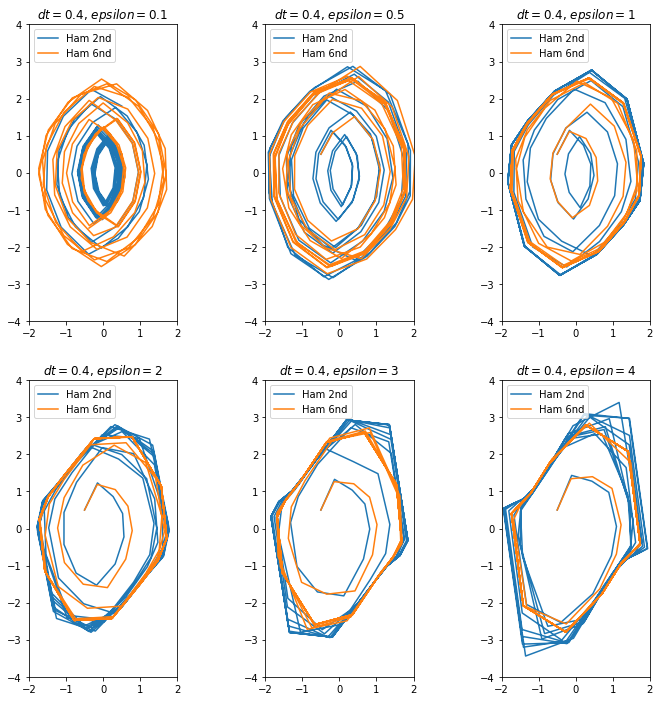

In [8]:
dt = 0.4
tf = 50
p0, q0, s0 = 0.0, -.5, 0.5

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    l1 = L1(epsilon)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step, l1, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, l1, tspan, p0, q0, s0)

    plt.plot(sol[:,1], sols,
             label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             label="Ham 6nd")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-2,2))
    plt.ylim((-4,4))

    plt.legend(loc='upper left')

plt.show()

In [9]:
# From: T. Harco, S. Liang:
# "Exact solutions of the Liénard- and generalized Liénard-type ordinary nonlinear differential equations obtained by deforming the phase space coordinates of the linear harmonic oscillator".
# Journal of Engineering Mathematics 98(1) (2015)

def explicit(n, beta, gamma, delta):
    def f(q):
        return -gamma*q + delta*q**n
        
    def fq(q):
        return -gamma + delta*n*q**(n-1)
    
    def F(q):
        return (beta-1)*q
    
    def Fq(q):
        return (beta-1)
    
    return Lienard(f, fq, F, Fq)

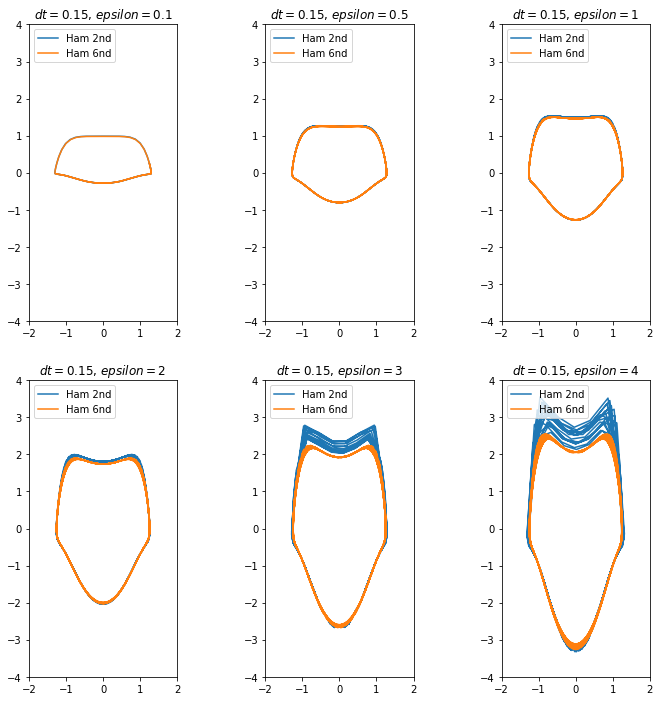

In [10]:
dt = 0.15
tf = 50
p0, q0, s0 = 0.0, 1.25, 0.25

tspan = np.linspace(0, tf, num=int(np.floor(tf/dt)))

plt.figure(figsize=(12,12))

for epsilon, spl in [(0.1, "231"), (0.5, "232"), (1, "233"), (2, "234"), (3, "235"), (4, "236")]:
    l1 = explicit(5, 1+epsilon, epsilon, 1+epsilon)
    
    plt.subplot(spl)
    plt.title(f"$dt={dt}$, $epsilon={epsilon}$")

    sol, sols, _ = ic.integrate(step, l1, tspan, p0, q0, s0)
    solm, solms, _ = ic.integrate(step6, l1, tspan, p0, q0, s0)

    plt.plot(sol[:,1], sols,
             label="Ham 2nd")
    plt.plot(solm[:,1], solms,
             label="Ham 6nd")

    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim((-2,2))
    plt.ylim((-4,4))

    plt.legend(loc='upper left')

plt.show()